In [1]:
import numpy as np
import scipy.stats as sps

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import gc

import typing as tp
from tqdm import tqdm_notebook


In [2]:
DIM = 10
M = 1000

def generate_dataset():
    sigmas = np.linspace(1, 10, DIM)
    optimal = np.ones(DIM)
    X = sps.multivariate_normal.rvs(size=M, mean=np.ones(DIM), cov=np.diag(sigmas))
    y = X @ optimal + sps.norm.rvs(loc=0, size=M)
    return X, y, optimal

In [4]:
X, y, theta_star = generate_dataset()

In [85]:
def calc_grad_scalar(theta):
    g = X.T @ (X @ theta - y)
    # print((X @ theta - y))
    # grs = np.multiply((X @ theta - y), X, axis=0)
    grs = (X @ theta - y)[:, None] * X
    return grs @ g


calc_grad_scalar(theta_star)

array([ 1.97242725e+03,  1.31054445e+03,  2.94854702e+02,  8.12577114e+02,
        4.55890452e+02,  5.94233548e+02,  1.04652047e+03, -1.61023463e+02,
       -1.29256815e+02,  5.62347978e+02, -2.89917731e+02, -2.65795965e+02,
        5.18710724e+02,  1.17587846e+01,  3.17063240e+01,  4.66935951e+02,
        8.31931227e+01, -7.86073298e+02, -6.20148894e+02,  1.14253894e+02,
       -2.79212028e+01, -2.61468368e+01,  5.73402866e+01,  2.75660234e+01,
        1.36038149e+03, -1.66683062e+01, -2.54671183e+02, -1.29080780e+02,
       -9.22406595e+01, -3.40459772e+02, -4.90780268e+02, -9.51802178e+02,
       -1.16989650e+02, -1.01929327e+03, -6.67278040e+02, -1.05461305e+02,
       -2.15573075e+01,  1.63445983e+02, -2.94660493e+02, -4.26125724e+01,
        4.51914573e+02,  1.56708345e+01,  4.64423235e+02,  1.28101806e+02,
       -4.52877390e+02,  1.63446844e+02,  1.79191443e+03,  3.66647176e+02,
       -4.29561079e+01, -1.01855649e+02, -1.80111025e+01, -1.49794609e+03,
       -7.81181183e+02, -

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Linear(DIM, 1)


    def forward(self, x):
        z = self.net(x)
        return z.flatten()

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output


def plot_loss(values):
    clear_output()
    with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
        train_loss = values["train_loss"]
        # accuracy = values["accuracy"]
        n = len(train_loss)

        plt.figure(figsize=(10, 5))
        
        # plt.subplot(1, 2, 1)
        plt.plot(range(1, n + 1), train_loss)
        plt.title('Train loss')

        # plt.subplot(1, 2, 2)
        # plt.plot(range(1, len(accuracy) + 1), accuracy)
        # plt.title('Accuracy Val')

        plt.show()

def get_list_grad_params(net: nn.Module) -> tp.List[torch.Tensor]:
    return [param.grad.detach().cpu() for param in net.parameters()]

def calc_grad_info(net: nn.Module, info: tp.List[torch.Tensor]):
    new_grads = get_list_grad_params(net)
    if not info:
        return new_grads
    return [new_grad + cur_grad for new_grad, cur_grad in zip(new_grads, info)]

def get_dif(grad_info_1: tp.List[torch.Tensor], grad_info_2: tp.List[torch.Tensor]) -> tp.List[torch.Tensor]:
    return [grad_1 - grad_2 for grad_1, grad_2 in zip(grad_info_1, grad_info_2)]

def mult_grad(info: tp.List[torch.Tensor], mult: float):
    return [grad * mult for grad in info] 

def get_grad_norm(grads: tp.List[torch.Tensor]):
    return np.sqrt(sum(grad.norm().item() ** 2 for grad in grads))

def get_cosinus_grad(grad_info_1: tp.List[torch.Tensor], grad_info_2: tp.List[torch.Tensor]) -> tp.List[torch.Tensor]:
    sc = sum([(grad_1 * grad_2).sum() for grad_1, grad_2 in zip(grad_info_1, grad_info_2)]).item()
    return sc / get_grad_norm(grad_info_1) / get_grad_norm(grad_info_2)


def train_cycle(
    model,
    optim,
    criterion,
    epochs,
    device,
    dataloader,
    mult: float,
    verbose=True,
    bound_batches = None,
    step: int = 1
):
    grad_history = []
    history = {}
    history["train_loss"] = []
    history["accuracy"] = []

    for _ in range(epochs):
        model.train()
        
        full_grad = []
        cur_grad = []
        for x, y in tqdm_notebook(dataloader):
            optim.zero_grad()
            x = x.to(device)
            logits = model(x)
            y_ = y.to(device)
            loss_batch = criterion(logits, y_)
            loss_batch.backward()
            full_grad = calc_grad_info(model, full_grad)
            cur_grad = mult_grad(get_list_grad_params(model), mult=mult)
            del x
            del y
            if 'cuda' in device:
                torch.cuda.synchronize()
                torch.cuda.empty_cache()
                gc.collect()

        grad_history.append((get_grad_norm(cur_grad),
                             get_grad_norm(full_grad),
                             get_grad_norm(get_dif(full_grad, cur_grad)),
                             get_cosinus_grad(cur_grad, full_grad)))
        optim.step()
        loss_ = loss_batch.detach().item()
        history["train_loss"].append(loss_)

        if verbose:
            plot_loss(history)

    return model, history, grad_history

In [8]:
class LinDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(X[idx]).type(torch.float32), torch.tensor(y[idx]).type(torch.float32)

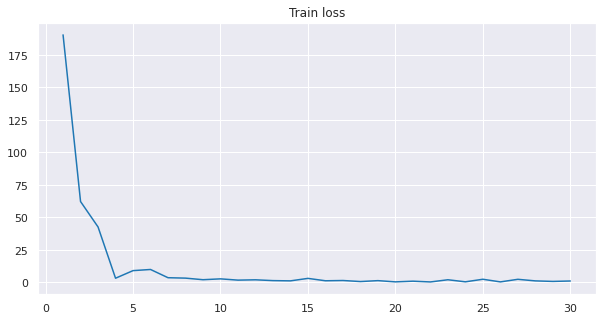

In [13]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = Net().to(device)

dataset_train = LinDataset(X, y)

batch_size: int = 32
workers: int = 6

dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                               num_workers=workers,
                                               batch_size=batch_size,
                                               sampler=torch.utils.data.RandomSampler(dataset_train))

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()
verbose = True

epochs = 30

model, history, grad_history = train_cycle(model,
                                           optimizer,
                                           criterion,
                                           epochs,
                                           device,
                                           dataloader_train,
                                           mult=len(dataset_train) / batch_size)

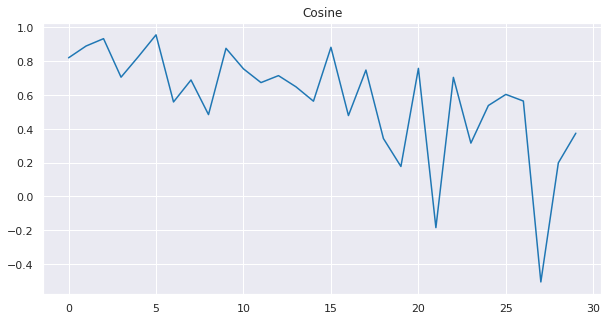

In [14]:
with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 5))

    #error = [grad[2] / grad[1] for grad in grad_history]
    #error = [g[2] for g in grad_history]
    error = [g[3] for g in grad_history]
    

    plt.plot(range(len(error)), error)
    plt.title('Cosine')

    plt.show()

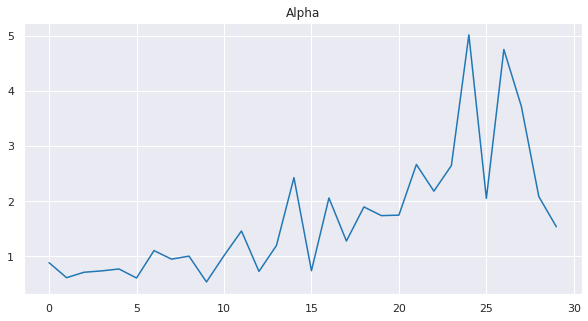

In [15]:
with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 5))

    error = [grad[2] / grad[1] for grad in grad_history]
    #error = [g[2] for g in grad_history]
    #error = [g[3] for g in grad_history]
    

    plt.plot(range(len(error)), error)
    plt.title('Alpha')

    plt.show()